<a href="https://colab.research.google.com/github/dcownden/PerennialProblemsOfLifeWithABrain/blob/split-and-simple-perturb/sequences/P2C1_Optimization/P2C1_Sequence4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following is part of a test for an upcoming text book on computational neuroscience from an optimization and learning perspective. The book will start with evolution because ultimately, all aspects of the brain are shaped by evolution and, as we will see, evolution can also be seen as an optimization algorithm. We are sharing it now to get feedback on what works and what does not and the developments we should do.

___
# **2.1.4: Learning Behaviour as a Form of High Dimensional Optimization**

### Objective: Explicitly connect the kinds of simple optimization process we saw in the previous sequences to learning adaptive behaviours.

In this sequence we will:

* Introduce a slightly more complex version of the strike-no-strike problem where the decision depends on 64 sensory inputs (features) instead of 1, and develop a simple artificial neural network that can learn to discriminate between when to strike and not strike based on these inputs.

* Use perturb-measure-step to train this network

* Adapt perturb-measure-step to
  - No longer require seperate perturbation and base evaluation modes
  - Learn from a single experiential episode (senory experience, action selection, resultant reward)

* See how performance is improved on the strike-no-strike discrimination task when using a more complex network to determine behaviour based on sensory input.


# Setup

Run the following cell to setup and install the various dependencies and helper functions for this .

In [1]:
# @title Dependencies, Imports and Setup
# @markdown You don't need to worry about how this code works – but you do need to **run the cell**
!apt install libgraphviz-dev > /dev/null 2> /dev/null #colab
!pip install ipympl pygraphviz vibecheck datatops jupyterquiz ucimlrepo > /dev/null 2> /dev/null #google.colab

import asyncio
import requests
from requests.exceptions import RequestException
import numpy as np
import itertools
import collections
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
from matplotlib.animation import FuncAnimation
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
import pygraphviz as pgv
import ipywidgets as widgets
import time
import logging
import random
import os
import copy
import torch
import warnings
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from io import BytesIO
from enum import Enum
from scipy.spatial.distance import cdist
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from tabulate import tabulate
from IPython.display import display, clear_output, Markdown, HTML, Image
from jupyterquiz import display_quiz
from vibecheck import DatatopsContentReviewContainer
from pathlib import Path
from typing import List, Dict
from tqdm.notebook import tqdm
from ucimlrepo import fetch_ucirepo
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
  return

data_set = fetch_ucirepo(id=80)
X = data_set.data.features.values
# Translate the data to have a minimum of 0
X_translated = X - X.min()
# Scale the data to have a range from 0 to 12 (which is 6 - (-6))
scaling_factor = 12 / (X.max() - X.min())
X_scaled = X_translated * scaling_factor
# Finally, shift the data to be centered between -6 and 6
X_final = X_scaled - 6

y = data_set.data.targets.values
rng = np.random.default_rng(seed=2021)
scramble_permutation = rng.permutation(X.shape[1])
Xs = X_final[:, scramble_permutation]
y1 = y % 2
y2 = np.array(y >= 5, dtype=y.dtype)
simple_index = ((y.flatten()==1) | (y.flatten()==0))
X_simple = Xs[simple_index]
y1_simple = y1[simple_index]
# if you only had one feature which would likely be best for discrimination
epsilon = 10
class_a_sep = np.mean(X_simple[y1_simple.flatten() == 1, :], axis=0) / (np.std(X_simple[y1_simple.flatten() == 1, :], axis=0) + epsilon)
class_b_sep = np.mean(X_simple[y1_simple.flatten() == 0, :], axis=0) / (np.std(X_simple[y1_simple.flatten() == 0, :], axis=0) + epsilon)
best_feature = np.argmax(class_a_sep - class_b_sep)
# print(f'Best feature is {best_feature}')
X_simple_1_feature = X_simple[:, [best_feature]]

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
# random seed settings and
# getting torch to use gpu if it's there


def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("This notebook isn't using and doesn't need a GPU. Good.")
  else:
    print("GPU is enabled in this notebook but not needed.")
    print("If possible, in the menu under `Runtime` -> ")
    print("`Change runtime type.`  select `CPU`")

  return device


SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()


def printmd(string):
  display(Markdown(string))


# the different utility .py files used in this notebook
filenames = []
# just run the code straight out of the response, no local copies needed!
for filename in filenames:
  url = f'https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/utils/{filename}'
  response = requests.get(url)
  # Check that we got a valid response
  if response.status_code == 200:
    code = response.content.decode()
    exec(code)
  else:
    print(f'Failed to download {url}')

# environment contingent imports
try:
  print('Running in colab')
  from google.colab import output
  output.enable_custom_widget_manager()
  from google.colab import data_table
  data_table.disable_dataframe_formatter()
  #from google.colab import output as colab_output
  #colab_output.enable_custom_widget_manager()
  IN_COLAB = True
except:
  IN_COLAB = False
  print('Not running in colab')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib widget
plt.style.use("https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/pplb.mplstyle")
plt.ioff() #need to use plt.show() or display explicitly
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


def remove_ip_clutter(fig):
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  fig.canvas.draw()


def content_review(notebook_section: str):
  return DatatopsContentReviewContainer(
    "",  # No text prompt
    notebook_section,
    {
      "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
      "name": "neuro_book",
      "user_key": "xuk960xj",
    },
  ).render()
feedback_prefix = "P2C1_S4"

Random seed 2021 has been set.
This notebook isn't using and doesn't need a GPU. Good.
Running in colab


# 2.1.4.1 Learning Strike-No-Strike with Perturb-Measure-Step.

Now that we know a bit about optimization in higher-dimensions we are going to introduce a harder, higher-dimensional version of our strike-no-strike problem. Whereas previously we had only a single input, now we are going to allow for 64 different inputs. So our cartoon organism that inspires this problem can now be thought of as having 64 photo-sensitive receptors, and based on this combination of inputs it must decide whether to strike or not. As before, the organism pays a cost of one if it strikes when it shouldn't and recieves a reward of one if it strikes when it should. It receives no cost or reward when it does not strike. To get a sense of this more complex discrimination problem, try it yourself by running the code cell below.

In [2]:
# @markdown **Run this cell** to try out the more complex 'strike-no-strike' discrimination task.

class InteractiveMNISTPredator():
  def __init__(self,
               features=Xs,
               labels=y,
               feedback_type='on_strike_only', seed=123):
    # Initialize dataset, settings for image scrambling and feedback
    self.features = features
    self.labels = labels
    # features is num_data_points x 64 (reshape to 8x8 for display, each cell 0-16)
    # labels is num_data_points x 1 (values 0-9 or 0/1 depending)
    self.feedback_type = feedback_type
    self.rng = np.random.default_rng(seed)
    sample_order = self.rng.permutation(self.features.shape[0])
    self.features = self.features[sample_order]
    self.labels = self.labels[sample_order]
    # initialize game state
    self.current_index = 0
    self.current_image = None
    self.previous_image = None
    self.score = 0
    self.best_possible_score = 0
    self.successful_strikes = 0
    self.failed_strikes = 0
    self.non_strikes = 0
    # Initialize widgets
    self.strike_button = widgets.Button(description='Strike')
    self.no_strike_button = widgets.Button(description='No Strike')
    self.score_display = widgets.Output()
    self.feedback_display = widgets.Output()

    # Initialize the figure for image display
    self.fig, self.ax = plt.subplots(figsize=(4, 4))
    remove_ip_clutter(self.fig)
    self.prev_fig, self.prev_ax = plt.subplots(figsize=(4, 4))
    remove_ip_clutter(self.prev_fig)
    self.show_next_image()
    # Bind event handlers
    self.strike_button.on_click(self.on_strike_clicked)
    self.no_strike_button.on_click(self.on_no_strike_clicked)

    # Arrange widgets in a layout
    buttons_layout = widgets.HBox([self.strike_button, self.no_strike_button])
    current_buttons = widgets.VBox([self.fig.canvas, buttons_layout])
    previous_feedback = widgets.VBox([self.prev_fig.canvas, self.feedback_display])
    self.ui = widgets.HBox([previous_feedback, current_buttons, self.score_display])

  def show_next_image(self):
    # Display the next image
    image = self.features[self.current_index]

    if len(image) == 64:
        image = image.reshape(8, 8)
    elif len(image) == 1:
      scalar_value = image.flatten()[0]
      # Initialize the 8x8 array with -6 (black)
      image = np.full((8, 8), -6.0)
      # Set the first ring to 6 (white)
      image[0, 0] = 6
      # Set the second ring to 6 (white)
      image[1:-1, 1:-1] = 6
      # Set the third (inner ring) back to -6 (black)
      image[2:-2, 2:-2] = -6
      # Assuming scalar_value is already in the range -6 to 6
      #print(scalar_value)
      image[3:-3, 3:-3] = scalar_value
    else:
      raise ValueError(f'Unexpected image shape: {image.shape}')
    if self.current_image is not None:
      self.previous_image = self.current_image
    self.current_image = image
    # Display the image
    #print(image)
    self.fig.clf()
    self.prev_fig.clf()
    self.ax = self.fig.add_subplot(111)
    self.prev_ax = self.prev_fig.add_subplot(111)
    self.ax.set_xlim(-.5, 7.5)
    self.ax.set_ylim(-0.5, 7.5)
    self.prev_ax.set_xlim(-.5, 7.5)
    self.prev_ax.set_ylim(-0.5, 7.5)
    self.ax.set_aspect('equal')
    self.prev_ax.set_aspect('equal')
    self.ax.axis('off')
    self.prev_ax.axis('off')
    self.ax.imshow(self.current_image, cmap='gray', vmin=-6, vmax=6)
    if self.previous_image is not None:
      self.prev_ax.imshow(self.previous_image, cmap='gray', vmin=-6, vmax=6)
    self.ax.set_title('Current Sensory Input')
    self.prev_ax.set_title('Previous Sensory Input')
    self.fig.canvas.draw()
    self.prev_fig.canvas.draw()

  def on_strike_clicked(self, button):
    self.process_decision('Strike')

  def on_no_strike_clicked(self, button):
    self.process_decision('No Strike')

  def process_decision(self, decision):
    # freeze buttons while we process
    self.strike_button.disabled = True
    self.no_strike_button.disabled = True

    # Process the user's decision, update score, and provide feedback
    correct_action = 'Strike' if self.labels[self.current_index] == 1 else 'No Strike'
    if decision == 'Strike':
      if decision == correct_action:
        self.score += 1
        self.successful_strikes += 1
      else:
        self.score -= 1
        self.failed_strikes += 1
    elif decision == 'No Strike':
      self.non_strikes += 1
      # no strike means no gain or loss
    else:
      raise ValueError(f'Unknown decision: {decision}')

    # Show feedback and score
    if (self.feedback_type == 'both' or
      (self.feedback_type == 'on_strike_only' and decision == 'Strike')):
      # Show informative feedback
      feedback = f'Your last choice: {decision}\nCorrect last choice: {correct_action}'
    else:
      # Show uninformative feedback
      feedback = 'Feedback only available after striking.'
    with self.feedback_display:
      clear_output(wait=True)
      print(feedback)

    # Show score
    with self.score_display:
      clear_output(wait=True)
      average_score = self.score / (self.current_index+1)
      print(f'Total Score: {self.score}')
      print(f'Number of Trials: {self.current_index + 1}')
      print(f'Successful Strikes: {self.successful_strikes}')
      print(f'Failed Strikes: {self.failed_strikes}')
      print(f'Non-Strikes: {self.non_strikes}')
      print(f'Average Score Per Trial: {average_score:.2f}')

    # Prepare the next image
    self.current_index += 1
    #print(self.current_index)
    self.show_next_image()
    # Re-enable buttons
    self.strike_button.disabled = False
    self.no_strike_button.disabled = False


scramble_bin_hard = InteractiveMNISTPredator(features=Xs,
                                             labels=y1,
                                             feedback_type='both')
display(scramble_bin_hard.fig.canvas)
display(scramble_bin_hard.prev_fig.canvas)
clear_output()
display(scramble_bin_hard.ui)

Maybe you were able to solve this with some savant like abstract pattern recognition powers. We were not able to learn to discriminate between the strike and no-strike situations over a dozen or so trials. The point here is that this is a non-trivial discrimination to learn. However, it is, as we will see in the next bit of code, a discrimination that a simple artificial neural network can learn to solve. (As before The dataset that underlies this strike-no-strike decision problem is sourced from the UCI Machine Learning Repository, Alpaydin,E. and Kaynak,C. 1998. https://doi.org/10.24432/C50P49.)

We model this creature's sensory-behaviour system much as before. Now though, $\mathbf{x}$ is the raw sensory input (vector) of length 64 in a given episode. Each element $x_i$ of $\mathbf{x}$ corresponds to the activation level of a single photosensitive neuron.

In [3]:
# the data set we're working with has 5620 example sensory inputs,
# each consisting of 64 values
print(Xs.shape)

(5620, 64)


In [4]:
# this is the first example
print(Xs[0].reshape(8,8,))

[[-1.5   0.   -4.5  -5.25  3.    5.25 -3.75 -6.  ]
 [-6.   -6.   -2.25 -0.75  4.5  -1.5  -6.   -6.  ]
 [-4.5  -6.   -6.   -6.   -6.   -6.   -0.75 -5.25]
 [-0.75  4.5  -3.75  0.75 -2.25 -1.5  -0.75  3.75]
 [-6.   -5.25  5.25  0.   -6.    1.5   3.   -0.75]
 [-6.   -6.   -6.   -6.   -5.25 -6.    3.75  6.  ]
 [-6.   -6.   -2.25 -6.   -6.    2.25 -6.   -1.5 ]
 [ 6.    6.   -6.   -6.   -3.   -6.    0.75 -6.  ]]


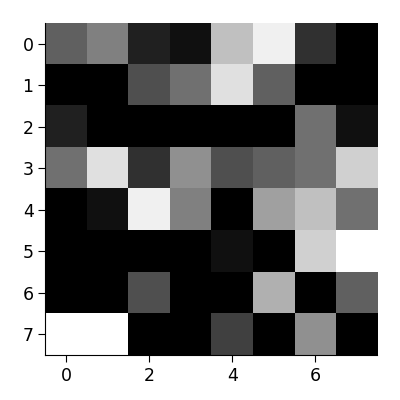

In [5]:
# visualizing the example we see that lower values correspond to darker pixels
# and higher values correspond to lighter values
fig, ax = plt.subplots(figsize=(4,4))
remove_ip_clutter(fig)
ax.imshow(Xs[0].reshape(8,8), cmap='gray')
plt.show()

These input neurons are then connected by synapses to a single output neuron. The activation level of this output neuron is computed as
$$z = \mathbf{Wx} + b$$
Here, $b$ is the (scalar) bias, or baseline activation level of the output neuron, and $\mathbf{W}$ is a matrix of synaptic weights between the input neurons and the single output neuron. (In this case where there is only one output neuron so $\mathbf{W}$ has shape 1x64 so could also be thought of as a row vector.)  

Often to simplify exposition and coding the input $\mathbf{x}$ is augmented to have a feature which is always 1, and then the bias terms can be treated as the weight connecting to this constant valued feature. That is

$$z = \mathbf{Wx}$$

Though now $\mathbf{W}$ has shape 1x65. As before, the probabilistic spiking of this output neuron determines the strike-no-strike behaviour of the organism, specifically:
$$ \Pr \{\text{strike}\} = \sigma(z) $$
$$ \Pr \{\text{no strike}\} = 1 - \sigma(z)$$

Recall that $\sigma(z): \frac{1}{1+e^{-z}} = \frac{e^z}{1+e^z}$ is the standard logistic (sigmoid) function.

The organism recieves a reward of 1 for striking at the right time and a penalty of -1 for striking at the wrong time. It also recieves a reward of zero when not striking, regardless of whether striking would have returned a reward or a penalty. Given this, complete the coding exercise below to write a function that determines the reward recieved for a given sensory input $\mathbf{x}$, the organism's probablistic response to the stimulus, $\Pr \{\text{strike}\} = \sigma(\mathbf{Wx})$, and the resultant outcome of the behaviour given the presence ($y=1$) or absence ($y=0$) of prey. Note that reward depends on three inputs, two $\mathbf{x}$ and $y$ have to do with the state of the environment, and are fully outside of the control of the organism, the other $\mathbf{W}$ determines the organism's response to the environment, and it is this $\mathbf{W}$, that the organism has some control over in that sense that $\mathbf{W}$ is what changes as a result of learning.

In [6]:
################################################################################
# TODO for students: Complete the lines with ... set the appropriate rewards for
# for the evaluations function
raise NotImplementedError("Exercise: Set the reward for different outcomes")
################################################################################

# As a little trick to keep our code cleaner we 'hide' our bias term.
# We to do this by augmenting the features to include a feature that always has the value '1'.
# Then, the 'weight' associated with this feature, which always has a value of '1', effectively serves as the bias term.
# After augmentation there is one extra column of features
Xs_aug = np.hstack([Xs, np.ones((Xs.shape[0],1))])

def np_sigmoid(x):
  x = np.clip(x, -500, 500) #prevent overflow, fine because sigmoid saturates
  return 1 / (1 + np.exp(-x))

def eval_params_stochastic_single(W, x, y, verbose=False, rng=None):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    W: (outputs(1) x inputs(65) np.array)
       weights between sensory neurons and output neuron
    x: (input(65) np.array) sensory input
    y: (outputs(1) np.array) target behavioural output

  Returns:
    R: the reward obtained given the parameters, inputs and targets
  """
  if rng is None:
    rng = np.random.default_rng()
  # activaation
  z = np.dot(W,x)
  # strike probability
  strike_prob = np_sigmoid(z)
  # what the organism actually does
  # rng.random is a sample from the uniform distribution on [0,1)
  did_strike = rng.random() < strike_prob
  if did_strike == True: #organism strikes
    if y == 1: #prey is present
      R = ...
    else: # prey is not present
      R = ...
  else: # organism does not strike
    R = ...
  if verbose:
    print(f'Probability of striking: {strike_prob}')
    action_string = 'Strike' if did_strike == True else 'No Strike'
    print(f'Action taken: {action_string}')
    target_string = 'Strike' if y == 1 else 'No Strike'
    print(f'Correct Action: {target_string}')
    print(f'Reward recieved: {R}')
  else:
    return R

eval_rng = np.random.default_rng(0)
W_test = np.zeros((1,65))
eval_params_stochastic_single(W_test, Xs_aug[0], y1[0], verbose=True, rng=eval_rng)

NotImplementedError: Exercise: Set the reward for different outcomes

In [7]:
# to_remove solution

# As a little trick to keep our code cleaner we 'hide' our bias term.
# We to do this by augmenting the features to include a feature that always has the value '1'.
# Then, the 'weight' associated with this feature, which always has a value of '1', effectively serves as the bias term.
# After augmentation there is one extra column of features
Xs_aug = np.hstack([Xs, np.ones((Xs.shape[0],1))])

def np_sigmoid(x):
  x = np.clip(x, -500, 500) #prevent overflow, fine because sigmoid saturates
  return 1 / (1 + np.exp(-x))

def eval_params_stochastic_single(W, x, y, verbose=False, rng=None):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    W: (outputs(1) x inputs(65) np.array)
       weights between sensory neurons and output neuron
    x: (input(65) np.array) sensory input
    y: (outputs(1) np.array) target behavioural output

  Returns:
    R: the reward obtained given the parameters, inputs and targets
  """
  if rng is None:
    rng = np.random.default_rng()
  # activaation
  z = np.dot(W,x)
  # strike probability
  strike_prob = np_sigmoid(z)
  # what the organism actually does
  # rng.random is a sample from the uniform distribution on [0,1)
  did_strike = rng.random() < strike_prob
  if did_strike == True: #organism strikes
    if y == 1: #prey is present
      R = 1
    else: # prey is not present
      R = -1
  else: # organism does not strike
    R = 0
  if verbose:
    print(f'Probability of striking: {strike_prob}')
    action_string = 'Strike' if did_strike == True else 'No Strike'
    print(f'Action taken: {action_string}')
    target_string = 'Strike' if y == 1 else 'No Strike'
    print(f'Correct Action: {target_string}')
    print(f'Reward recieved: {R}')
  else:
    return R

eval_rng = np.random.default_rng(0)
W_test = np.zeros((1,65))
eval_params_stochastic_single(W_test, Xs_aug[0], y1[0], verbose=True, rng=eval_rng)

Probability of striking: [0.5]
Action taken: No Strike
Correct Action: No Strike
Reward recieved: 0


So that evaluates the reward over a single experience. We can use numpy broadcasting to apply this same reward calculation efficiently to many, even all, the input-out pairs in our data set. We call this **batch** evaluation.

In [8]:
################################################################################
# TODO for students: Complete the lines with ... to compute the number of
# True Positives, False Positives, True Negative and False Negatives in the batch
raise NotImplementedError("Exercise: Compute the number of different Outcomes")
################################################################################

# to_remove solution

# As a little trick to keep our code cleaner we 'hide' our bias term.
# We to do this by augmenting the features to include a feature that always has the value '1'.
# Then, the 'weight' associated with this feature, which always has a value of '1', effectively serves as the bias term.
# After augmentation there is one extra column of features
Xs_aug = np.hstack([Xs, np.ones((Xs.shape[0],1))])

def np_sigmoid(x):
  x = np.clip(x, -500, 500) #prevent overflow, fine because sigmoid saturates
  return 1 / (1 + np.exp(-x))

def eval_params_stochastic_batch(W, x, y, verbose=False, rng=None):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    W: (outputs(1) x inputs(65) np.array)
       weights between sensory neurons and output neuron
    x: (input(65) x batch np.array) sensory input
    y: (outputs(1) x batch np.array) target behavioural output

  Returns:
    R: the reward obtained given the parameters, inputs and targets
  """
  if rng is None:
    rng = np.random.default_rng()
  if rng is None:
    rng = np.random.default_rng()
  # activation
  z = np.dot(W,x) # 1 x batch
  # strike probability
  strike_probs = np_sigmoid(z) # 1 x batch
  # what the organism actually does
  # rng.random is a sample from the uniform distribution on [0,1)
  did_strike = rng.random(size=strike_probs.shape) < ...  # 1 x batch
  R = np.zeros(did_strike.shape)
  did_not_strike = ...
  should_strike = ...
  should_not_strike = ...
  TP = np.logical_and(did_strike, should_strike) # True Positive
  FP = np.logical_and(did_strike, should_not_strike) # False Positive
  FN = np.logical_and(did_not_strike, should_strike) # False Negative
  TN = np.logical_and(did_not_strike, should_not_strike) # True Negative
  R[TP] = 1
  R[FP] = -1
  R[FN] = 0
  R[TN] = 0
  TPs = np.sum(TP)
  FPs = np.sum(FP)
  FNs = np.sum(FN)
  TNs = np.sum(TN)
  confusion_matrix = np.array([[TPs, FNs], [FPs, TNs]])
  if verbose:
    table = [["Should Strike", TPs, FNs],
                 ["Shouldn't Strike", FPs, TNs]]
    headers = ["", "Did Strike", "Didn't Strike"]
    print("Confusion_matrix: ")
    print(tabulate(table, headers=headers, tablefmt="grid"))
    print(f'Total Reward: {np.sum(R)}')
    return None
  else:
    return np.sum(R), confusion_matrix

eval_rng = np.random.default_rng(0)
W_test = np.zeros((1,65))
# Xs_aug and y1 are batch x 65 and batch x 1, function wants transpose of this shape
# for broadcasting to work
print('Evaluation 1')
eval_params_stochastic_batch(W_test, Xs_aug.T, y1.T, verbose=True, rng=eval_rng)
print('\nEvaluation 2')
eval_params_stochastic_batch(W_test, Xs_aug.T, y1.T, verbose=True, rng=eval_rng)

NotImplementedError: Exercise: Compute the number of different Outcomes

In [9]:
# to_remove solution

# As a little trick to keep our code cleaner we 'hide' our bias term.
# We to do this by augmenting the features to include a feature that always has the value '1'.
# Then, the 'weight' associated with this feature, which always has a value of '1', effectively serves as the bias term.
# After augmentation there is one extra column of features
Xs_aug = np.hstack([Xs, np.ones((Xs.shape[0],1))])

def np_sigmoid(x):
  x = np.clip(x, -500, 500) #prevent overflow, fine because sigmoid saturates
  return 1 / (1 + np.exp(-x))

def eval_params_stochastic_batch(W, x, y, verbose=False, rng=None):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    W: (outputs(1) x inputs(65) np.array)
       weights between sensory neurons and output neuron
    x: (input(65) x batch np.array) sensory input
    y: (outputs(1) x batch np.array) target behavioural output

  Returns:
    R: the reward obtained given the parameters, inputs and targets
  """
  if rng is None:
    rng = np.random.default_rng()
  if rng is None:
    rng = np.random.default_rng()
  # activation
  z = np.dot(W,x) # 1 x batch
  # strike probability
  strike_probs = np_sigmoid(z) # 1 x batch
  # what the organism actually does
  # rng.random is a sample from the uniform distribution on [0,1)
  did_strike = rng.random(size=strike_probs.shape) < strike_probs  # 1 x batch
  R = np.zeros(did_strike.shape)
  did_not_strike = np.logical_not(did_strike)
  should_strike = y == 1
  should_not_strike = y == 0
  TP = np.logical_and(did_strike, should_strike) # True Positive
  FP = np.logical_and(did_strike, should_not_strike) # False Positive
  FN = np.logical_and(did_not_strike, should_strike) # False Negative
  TN = np.logical_and(did_not_strike, should_not_strike) # True Negative
  R[TP] = 1
  R[FP] = -1
  R[FN] = 0
  R[TN] = 0
  TPs = np.sum(TP)
  FPs = np.sum(FP)
  FNs = np.sum(FN)
  TNs = np.sum(TN)
  confusion_matrix = np.array([[TPs, FNs], [FPs, TNs]])
  if verbose:
    table = [["Should Strike", TPs, FNs],
                 ["Shouldn't Strike", FPs, TNs]]
    headers = ["", "Did Strike", "Didn't Strike"]
    print("Confusion_matrix: ")
    print(tabulate(table, headers=headers, tablefmt="grid"))
    print(f'Total Reward: {np.sum(R)}')
    return None
  else:
    return np.sum(R), confusion_matrix

eval_rng = np.random.default_rng(0)
W_test = np.zeros((1,65))
# Xs_aug and y1 are batch x 65 and batch x 1, function wants transpose of this shape
# for broadcasting to work
print('Evaluation 1')
eval_params_stochastic_batch(W_test, Xs_aug.T, y1.T, verbose=True, rng=eval_rng)
print('\nEvaluation 2')
eval_params_stochastic_batch(W_test, Xs_aug.T, y1.T, verbose=True, rng=eval_rng)

Evaluation 1
Confusion_matrix: 
+------------------+--------------+-----------------+
|                  |   Did Strike |   Didn't Strike |
+==================+==============+=================+
| Should Strike    |         1386 |            1443 |
+------------------+--------------+-----------------+
| Shouldn't Strike |         1420 |            1371 |
+------------------+--------------+-----------------+
Total Reward: -34.0

Evaluation 2
Confusion_matrix: 
+------------------+--------------+-----------------+
|                  |   Did Strike |   Didn't Strike |
+==================+==============+=================+
| Should Strike    |         1419 |            1410 |
+------------------+--------------+-----------------+
| Shouldn't Strike |         1404 |            1387 |
+------------------+--------------+-----------------+
Total Reward: 15.0


Note that the two evaluations give different total rewards, even though the exact same synaptic weights $\mathbf{W}$ are being used, on the exact same batch of inputs $\mathbf{x}$ and prey presence indicators $y$. This is expected given the inherent stochasticity in the organism's behaviour. This stochastic evaluation of the synaptic weights will make things difficult for the perturb-measure-step alogorithm though, because it relies upon precise function evaluations to get good estimates of the rate of improvement in a given direction in parameter space. We can overcome this stochastic evaluation issue though by using our knowledge of how the different probabilities of striking or not determine the expected, or average reward. By directly evaluating expected reward we can recover a precise, deterministic evaluation function.

In [10]:
def eval_params_expectation_batch(W, x, y, verbose=False):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    W: (outputs(1) x inputs(65) np.array)
       weights between sensory neurons and output neuron
    x: (input(65) x batch np.array) sensory input
    y: (outputs(1) x batch np.array) target behavioural output

  Returns:
    R_exp: the expected reward obtained over the batch given the parameters, inputs and targets
  """
  # activaation
  a = np.dot(W,x) # 1 x batch
  # strike probability
  y_hat = np_sigmoid(a) # 1 x batch
  # Expected true positives (TPs) and false positives (FPs)
  TPs = np.sum(y_hat * y)  # Sum of strike probabilities where true label is 1
  FPs = np.sum(y_hat * (1 - y))  # Sum of strike probabilities where true label is 0
  # Expected false negatives (FN_e) and true negatives (TN_e)
  FNs = np.sum((1 - y_hat) * y)  # Sum of no strike probabilities where true label is 1
  TNs = np.sum((1 - y_hat) * (1 - y))  # Sum of no strike probabilities where true label is 0
  R_exp = 1 * TPs + 0 * FNs + -1 * FPs + 0 * TNs
  confusion_matrix = np.array([[TPs, FNs], [FPs, TNs]])
  if verbose:
    table = [["Should Strike", TPs, FNs],
             ["Shouldn't Strike", FPs, TNs]]
    headers = ["", "Did Strike", "Didn't Strike"]
    print("Confusion_matrix: ")
    print(tabulate(table, headers=headers, tablefmt="grid"))
    print(f'Total Reward: {R_exp}')
    return None
  else:
    return R_exp, confusion_matrix

W_test = np.zeros((1,65))
# Xs_aug and y1 are batch x 65 and batch x 1, function wants transpose of this shape
# for broadcasting to work
print('Evaluation 1')
eval_params_expectation_batch(W_test, Xs_aug.T, y1.T, verbose=True)
print('\nEvaluation 2')
eval_params_expectation_batch(W_test, Xs_aug.T, y1.T, verbose=True)

Evaluation 1
Confusion_matrix: 
+------------------+--------------+-----------------+
|                  |   Did Strike |   Didn't Strike |
+==================+==============+=================+
| Should Strike    |       1414.5 |          1414.5 |
+------------------+--------------+-----------------+
| Shouldn't Strike |       1395.5 |          1395.5 |
+------------------+--------------+-----------------+
Total Reward: 19.0

Evaluation 2
Confusion_matrix: 
+------------------+--------------+-----------------+
|                  |   Did Strike |   Didn't Strike |
+==================+==============+=================+
| Should Strike    |       1414.5 |          1414.5 |
+------------------+--------------+-----------------+
| Shouldn't Strike |       1395.5 |          1395.5 |
+------------------+--------------+-----------------+
Total Reward: 19.0


Note that as hoped, the evaluation of parameters using expected reward, is consistent, as it should be. As a sanity check we see that the distribution of stochastic evaluations is roughly symmetric, and centered around this expectation, with the average of many such stochastic evaluations becoming close to our calculated expected value.

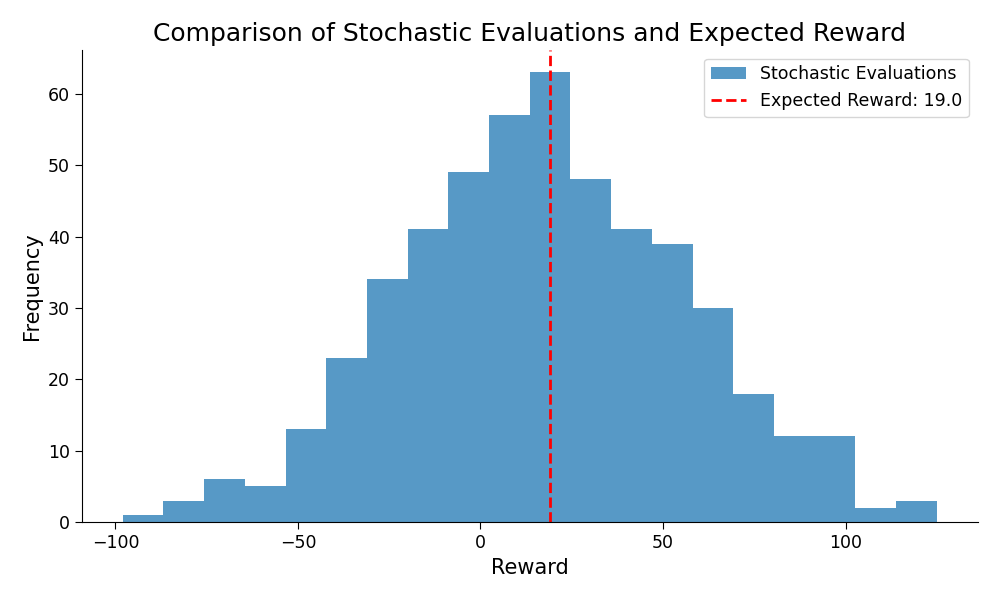

In [11]:
# @markdown **Run this cell** to visualize the distribution of stochastic parameter evaluation, relative to the expectation.
def eval_params_expectation_batch(W, x, y, verbose=False):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    W: (outputs(1) x inputs(65) np.array)
       weights between sensory neurons and output neuron
    x: (input(65) x batch np.array) sensory input
    y: (outputs(1) x batch np.array) target behavioural output

  Returns:
    R_exp: the expected reward obtained over the batch given the parameters, inputs and targets
  """
  # activaation
  a = np.dot(W,x) # 1 x batch
  # strike probability
  y_hat = np_sigmoid(a) # 1 x batch
  # Expected true positives (TPs) and false positives (FPs)
  TPs = np.sum(y_hat * y)  # Sum of strike probabilities where true label is 1
  FPs = np.sum(y_hat * (1 - y))  # Sum of strike probabilities where true label is 0
  # Expected false negatives (FN_e) and true negatives (TN_e)
  FNs = np.sum((1 - y_hat) * y)  # Sum of no strike probabilities where true label is 1
  TNs = np.sum((1 - y_hat) * (1 - y))  # Sum of no strike probabilities where true label is 0
  R_exp = 1 * TPs + 0 * FNs + -1 * FPs + 0 * TNs
  confusion_matrix = np.array([[TPs, FNs], [FPs, TNs]])
  if verbose:
    table = [["Should Strike", TPs, FNs],
             ["Shouldn't Strike", FPs, TNs]]
    headers = ["", "Did Strike", "Didn't Strike"]
    print("Confusion_matrix: ")
    print(tabulate(table, headers=headers, tablefmt="grid"))
    print(f'Total Reward: {R_exp}')
    return None
  else:
    return R_exp, confusion_matrix

def eval_params_stochastic_batch(W, x, y, verbose=False, rng=None):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    W: (outputs(1) x inputs(65) np.array)
       weights between sensory neurons and output neuron
    x: (input(65) x batch np.array) sensory input
    y: (outputs(1) x batch np.array) target behavioural output

  Returns:
    R: the reward obtained given the parameters, inputs and targets
  """
  if rng is None:
    rng = np.random.default_rng()
  # activaation
  a = np.dot(W,x) # 1 x batch
  # strike probability
  y_hat = np_sigmoid(a) # 1 x batch
  # what the organism actually does
  # rng.random is a sample from the uniform distribution on [0,1)
  y_sample = rng.random(size=y_hat.shape) < y_hat  # 1 x batch
  R = np.zeros(y_sample.shape)
  did_strike = y_sample == 1
  did_not_strike = y_sample == 0
  should_strike = y == 1
  should_not_strike = y == 0
  TP = np.logical_and(did_strike, should_strike) # True Positive
  FP = np.logical_and(did_strike, should_not_strike) # False Positive
  FN = np.logical_and(did_not_strike, should_strike) # False Negative
  TN = np.logical_and(did_not_strike, should_not_strike) # True Negative
  R[TP] = 1
  R[FP] = -1
  R[FN] = 0
  R[TN] = 0
  TPs = np.sum(TP)
  FPs = np.sum(FP)
  FNs = np.sum(FN)
  TNs = np.sum(TN)
  confusion_matrix = np.array([[TPs, FNs], [FPs, TNs]])
  if verbose:
    table = [["Should Strike", TPs, FNs],
                 ["Shouldn't Strike", FPs, TNs]]
    headers = ["", "Did Strike", "Didn't Strike"]
    print("Confusion_matrix: ")
    print(tabulate(table, headers=headers, tablefmt="grid"))
    print(f'Total Reward: {np.sum(R)}')
    return None
  else:
    return np.sum(R), confusion_matrix

W_test = np.zeros((1,65))
exp_reward, _ = eval_params_expectation_batch(W_test, Xs_aug.T, y1.T, verbose=False)

# Generate stochastic rewards
stochastic_rewards = []
for _ in range(500):  # Simulate 100 times to create a distribution
  r, _ = eval_params_stochastic_batch(W_test, Xs_aug.T, y1.T, verbose=False)
  stochastic_rewards.append(r)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
remove_ip_clutter(fig)
ax.hist(stochastic_rewards, bins=20, alpha=0.75, label='Stochastic Evaluations')
ax.axvline(x=exp_reward, color='r', linestyle='dashed', linewidth=2, label=f'Expected Reward: {exp_reward}')
ax.set_title('Comparison of Stochastic Evaluations and Expected Reward')
ax.set_xlabel('Reward')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()

As yet another sanity check we calculate the expected reward when striking and not striking with equal probability, in all circumstances, which is what we expect from a $\mathbf{W}$ of all zeros.

In [12]:
# There are this many cases where striking is good
np.sum(y1 == 1)

2829

In [13]:
# And this many cases where striking is bad
np.sum(y1 == 0)

2791

In [14]:
# W = 0 should strike half the time no matter what,
# in which case would expect a reward of
(2829 - 2791) / 2

19.0

That all checks out, so now that we have some confidence in our evaluation function let's see if perturb-measure-step is able to find a good set of values for $\mathbf{W}$ using the batch expected value version of parameter evaluation. Execture the code cell below to run this the training loop. The process will take a minute or two to complete, while its running read through the code and see if you can make sense of what it is doing

In [15]:
# @title Perturb-Measure-Step Training Loop
learn_rng = np.random.default_rng(0)
num_steps = 60000
step_scale = 0.002
dimensional_scale_factor = np.sqrt(65)
perturbation_scale = 0.0001 # std of gaussian test perturbations
W_init = np.zeros((1,65))
W = W_init
start_time = time.time()
for step in range(num_steps):
  R_current, _ = eval_params_expectation_batch(W, Xs_aug.T, y1.T)
  raw_test_perturb = learn_rng.standard_normal(size=(1,65))
  unit_test_perturb = raw_test_perturb / np.linalg.norm(raw_test_perturb.flatten())
  test_perturbation = unit_test_perturb * perturbation_scale
  R_test, _ = eval_params_expectation_batch(W + test_perturbation, Xs_aug.T, y1.T)
  directional_grad_est = (R_test - R_current) / perturbation_scale
  W += step_scale * dimensional_scale_factor * directional_grad_est * unit_test_perturb

  if step == 0 or (step + 1) % 3000 == 0:
    elapsed_time = time.time() - start_time
    print(f'Step {step + 1}/{num_steps} | Expected Full Batch Reward: {R_current:.6f} | Time: {elapsed_time:.2f}s | Avg. Time Per Step: {1000*elapsed_time/(step+1):.2f}ms')
eval_params_expectation_batch(W, Xs_aug.T, y1.T, verbose=True)

Step 1/60000 | Expected Full Batch Reward: 19.000000 | Time: 0.01s | Avg. Time Per Step: 8.92ms
Step 3000/60000 | Expected Full Batch Reward: 2465.388192 | Time: 4.72s | Avg. Time Per Step: 1.57ms
Step 6000/60000 | Expected Full Batch Reward: 2481.044387 | Time: 7.64s | Avg. Time Per Step: 1.27ms
Step 9000/60000 | Expected Full Batch Reward: 2491.196364 | Time: 11.48s | Avg. Time Per Step: 1.28ms
Step 12000/60000 | Expected Full Batch Reward: 2493.919487 | Time: 16.01s | Avg. Time Per Step: 1.33ms
Step 15000/60000 | Expected Full Batch Reward: 2493.363589 | Time: 18.97s | Avg. Time Per Step: 1.26ms
Step 18000/60000 | Expected Full Batch Reward: 2499.385890 | Time: 21.95s | Avg. Time Per Step: 1.22ms
Step 21000/60000 | Expected Full Batch Reward: 2502.837441 | Time: 25.70s | Avg. Time Per Step: 1.22ms
Step 24000/60000 | Expected Full Batch Reward: 2499.388272 | Time: 30.47s | Avg. Time Per Step: 1.27ms
Step 27000/60000 | Expected Full Batch Reward: 2509.477245 | Time: 33.42s | Avg. Time

The best possible score is 2829, and perturb measure step is able to discover network parameters that achieve a score of roughly 2500, in 60,000 steps. This is pretty good, better than we the humans were able to do in terms of figuring out the pattern, before we got bored of the problem in a few minutes. This is all well and good as an optimization exercise, but if we want to connect this form of optimization back to our inspirational cartoon of neural behaviour as a kind of learning, there are a few issues. Three major issues stand out as ways in which the perturb-measure-step training loop above deviates from a process that is simple and local enough to serve as plausible (even if very abstract) model of a physiological syanptic plasticity processes. These key issues are:
1. The organism's striking behaviour is stochastic but expected reward outcomes, not actual obtained reward outcomes are used to drive updates to the synaptic parameters $\mathbf{W}$.
2. The evaluation of a given synaptic configuration is based on performance over all of the 5620 of distcint input-outpur pairs (sensory-pattern, prey-presence) in the data set that defines the "environment" of this learning problem. Physiologically viable would be evaluations over a single, or at least relatively few, stimulus-response-reward episodes.
3. Evaluations are performed in seperate perturbation and non-perturbation modes in the training loop above. A single mode of evaluation that operated fully "online" and in congunction with the ongoing generation of behaviour is more simple and easy to imagine physiological implementations of.

There are of course many other ways in which the this cartoon learning system deviates from what might plausibly be implemented in an actual simple neural system, but these have more to do with the abstractness of the model, and can concievibly be remedied with careful choices about how to make the model more concrete so as to map nicely onto measurable phyiological features of neural plasticity. In contrast, for the critical points oulined above, it is difficult to imagine how any of these key issues can be overcome physiologically, without invoking additional complex neural circuits and processes, the orgin of which also need to be explained. So for this sequence and the next we focus on addressing these core issues: tracking base versus perturbation evaluation, using batched instead of single experience based reward to drive learning, and using expected versus actual recieved (stochastic) reward to drive learning.

In the rest of this sequence we will adapt the base perturb-measure-step update rule to address each of these three issues. But first let's just get a bit of a sense of how these issues impinge upon the fantasy of using perturb-measure-step as an algorithm that might feasibly be used by a living organism to update the connection strengths of this simple network determining behaviour in response to stimulus. In each interation in the vanilla perturb-measure-step training loop implemented above the organism first evaluates its current parameters based on the expected reward over all 5620 possible experiences. It then perturbs its synaptic parameters and evaluates its performance again on all 5620 experiences, these two evaluations are compared to determine $\Delta R$ and this together with the pertrubations $\Delta W_i$ determine the synaptic connections update according to

$$ W_i' = W_i + s \ \Delta W_i \ \Delta R $$
where
$$\Delta R = R(\mathbf{W} + \Delta \mathbf{W}) - R(\mathbf{W})$$
and $R(\mathbf{W})$ is our reward/evaluation function.
Note that $s$ needs to be carefully choosen to account both for the average size of the perturbation $\| \mathbf{W} \|$, the appropriately level of scaling given the expected alignment of a random perturbation with the gradient given the dimensionality of $\mathbf{W}$, and the relative scale of the gradient. While this is can be a challenge in practical applications, the "dialing-in" of meta-parameters of learning algorithms is something that we expect evolution to be quite good at.

This process would require the organism somehow integrate all of the reward outcomes of all 5620 experiences, remember this aggregated outcome, then integrate up the reward outcomes of another 5620 experiences accumulated while in 'perturbation' mode, and then update its parameters based on a comparison of the remembered and the recently accumlated aggregate reward outcome. This all seems a bit complicated, and difficult to implement with simple, primarily local, synaptic plasticity mechanisms. What we would like intead is a version of perturb-measure-step that updates its synaptic weights as a result of every reward experience, doesn't rely on an expected reward calculation, and that does not have a seperate perturbation mode.

Removing the seperate perturbation mode is perhaps the easiest issue to address so we take this on first.

In [16]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M1")

# 2.1.4.2 Step-Measure-Step (ALOPEX)

One simple way to avoid a seperate perturbation evaluation is to simply compress the perturbation and the update into a single step. We call such an update method step-measure-step as contrasted with perturb measure step. This new update rule looks like this.



$$\ W_{i}(t+1)= W_i(t) + s \ (W_i(t) - W_i(t-1)) \ \ R(\mathbf{W}(t)) - R(\mathbf{W}(t-1)) + \xi_{i}(t)$$

Previously we used $\Delta$ to denote the perturbation and did not directly reference the parameter update. Because now we are combining the perturbation and the parameter update we use $\Delta$ to denote this combined change, that is
$$ \ W_{i}(t+1) - W_i(t) = \Delta W_i(t) $$

Then the above simplifies

$$ \Delta W_i(t) = s \ \Delta W_i(t-1) \ \Delta R(t) + \xi_i(t) $$
Here $\Delta R(t) = R(\mathbf{W}(t)) - R(\mathbf{W}(t-1))$

Run the code cell below to see if this works.


In [17]:
# @title Step-Measure-Step Training Loop
learn_rng = np.random.default_rng(0)
num_steps = 100000
init_step_scale = 0.003 * np.sqrt(65)
init_noise_scale = 0.0005
total_scale = 1.0
#later_step_scale = 0.002 * np.sqrt(65)
#later_noise_scale = 0.0001
W_init = np.zeros((1,65))
W = W_init
delta_W = np.zeros((1,65))
R, _ = eval_params_expectation_batch(W, Xs_aug.T, y1.T)
start_time = time.time()
step_scale = init_step_scale
noise_scale = init_noise_scale
for step in range(num_steps):
  R_old = R
  R, _ = eval_params_expectation_batch(W, Xs_aug.T, y1.T)
  delta_R = R - R_old
  delta_W_noise = learn_rng.normal(0, noise_scale, size=(1,65))
  delta_W = total_scale * (step_scale * delta_W * delta_R + delta_W_noise)
  W += delta_W

  if step == 0 or (step + 1) % 10000 == 0:
    elapsed_time = time.time() - start_time
    #print(f'Delta R: {delta_R}')
    #print(f'Delta W: {delta_W}')
    print(f'Step {step + 1}/{num_steps} | Expected Full Batch Reward: {R:.6f} | Time: {elapsed_time:.2f}s | Avg. Time Per Step: {1000*elapsed_time/(step+1):.2f}ms')
    #if step > 40000:
    #  step_scale = later_step_scale
    #  noise_scale = later_noise_scale
eval_params_expectation_batch(W, Xs_aug.T, y1.T, verbose=True)

Step 1/100000 | Expected Full Batch Reward: 19.000000 | Time: 0.00s | Avg. Time Per Step: 1.68ms
Step 10000/100000 | Expected Full Batch Reward: 1606.922149 | Time: 5.13s | Avg. Time Per Step: 0.51ms
Step 20000/100000 | Expected Full Batch Reward: 1714.935587 | Time: 11.33s | Avg. Time Per Step: 0.57ms
Step 30000/100000 | Expected Full Batch Reward: 1777.267511 | Time: 17.37s | Avg. Time Per Step: 0.58ms
Step 40000/100000 | Expected Full Batch Reward: 1859.405580 | Time: 23.26s | Avg. Time Per Step: 0.58ms
Step 50000/100000 | Expected Full Batch Reward: 1929.047608 | Time: 30.73s | Avg. Time Per Step: 0.61ms
Step 60000/100000 | Expected Full Batch Reward: 1951.763270 | Time: 35.61s | Avg. Time Per Step: 0.59ms
Step 70000/100000 | Expected Full Batch Reward: 1960.317681 | Time: 42.92s | Avg. Time Per Step: 0.61ms
Step 80000/100000 | Expected Full Batch Reward: 1969.088658 | Time: 56.33s | Avg. Time Per Step: 0.70ms
Step 90000/100000 | Expected Full Batch Reward: 1968.523797 | Time: 64.6

So this trick of smushing the perturbation and the update into a single step seems to work okay, though not as well as doing the very careful perturbation, but it shows that much of the correct pattern response to stimulus can be discovered through this mode. This particular idea for smushing together the perturbation and the update  is known as ALOPEX (an acronym from "ALgorithms Of Pattern EXtraction", first proposed by Tzanakou and Harth in 1974.) This is one way of not having a seperate perturbation and non-perturbation mode. There are other ways, such as leveraging the stochasticity of relative spike timings (ref seung), and using reward signals directly to drive learning. We will discuss these later. For now, it is enough to know that this issue can be mitigated, though with some apparrent cost to overall performance (relative to perturb-measure-step).

Another point of comparison here is that the average time per step is almost half that of perturb-measure-step. This is to be expected since perturb-measure-step requires two evaluations per step, whereas this step-measure-step only requires a single evaluation per step. However, this results in each step leading to less improvement, so that even though 100 thousand steps have been taken by step-measure-step, overall performance is not as good as that of perturb-measure-step after just 60 thousand steps.

Moving on to the next issue.

_______________________________________________________________________
# Algo Box: Comparing Algorithm Speed—Clock Time versus Iterations
(This Box Needs Help)

When comparing the "speed" of algoriths, the quantity of greatest practical interest is the total time taken to reach a "good" solution according to some criterion for some specific problem. Total time taken can be decomposed as follows

$$
\text{Total Time Taken} = \text{Iterations Required} \times \text{Average Time per Iteration}
$$

Breaking down the total clock time into these components provides insight in the following ways:

   - **Iterations Required:** This metric reflects the abstract properties of the algorithm—its inherent efficiency and suitability for the problem at hand. It’s independent of the computing environment, which makes it valuable for theoretical comparisons across different settings.

   - **Time Per Iteration:** This measures how long each cycle of the algorithm's process takes, influenced by two sub-factors:
     - **Computational Complexity:** The inherent difficulty and amount of computation involved in each iteration of the algorithm. This is another abstraction, again useful for general comparisons
     - **Implementation Efficiency:** How well the algorithm's computational steps are optimized for the hardware it runs on, including factors like code optimization and hardware utilization. While these factors are very specific to the compuational context of the algorithm, in practical engineering setting, especially when dealing with large models and lots of data, these factors can be of paramount importance.

While theorists are of course drawn to things like iterations required and computational complexity, implementation efficiency is also of profound importance. As an example the current "AI Revolution" was catalyzed in part by co-opting GPU's, mass-market high-performance hardware designed to make video games look good, for the more niche academic application of multiplying matrices quickly. (This is not so odd as it might seem as transforming abstract video-game states into 3d models and then into 2d projections for a screen at 60 frames per second involves a lot multiplying matrices quickly.)

(In much the same way the theoretical underpinnings of Bayesian MCMC approaches were well understood for many decades prior to the this approach to inference becoming of any practical use with the advent of widely available fast, parrellel computation, and efficient implementations)

Implementation efficiency is something that we have to be especially aware of when jumping between computational platforms. An algorithm that is inefficient in some ways, but is easily parallelizable may be overall more effective when implemented on hardware that supports parllelization. Different algorithms allow for diffent kinds of implementation. An algorithm that requires many steps, each of great complexity might seem slow, but if those steps and complexity can be parellized out at the synapse level, i.e. very "efficiently" implemented in the brain, then perhaps overall it is a fast algorithm. Everything matters.

_______________________________________________________________________


In [18]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M2")

# 2.1.4.3 Full-Batch versus Mini-Batch Perturb-Measure-Step

Another issue in terms of physiological viability was parameter evaluation based on performance across all possible experiences. In a simple model of learning and synaptic plasticity, we would like learning to be driven by the outcomes of a single stimulus-response-reward experience.

This relates to an important idea in machine learning. The idea of the mini-batch. In a simple ML context we are (for now at least) interested in the performance of the parameters in aggregate over every input-target pair in the data set. For a large data set evaluation over the entire data set can become computationally costly. However, it is typically possible to *estimate* performance over the entire data using a small random sample of the input-target pairs in the data set. Such a sample of data points is called a mini-batch of the data. (As contrasted with the entire data-set which is called a full-batch or just batch). In the extreme case a mini-batch can consist of a single input-output pair. In this extreme case we will have moved to a situation where the organism is learning based on a single episode of sensory expereience, action selection and reward. Let's see what having a mini-batch of different sizes does to how quickly it takes for perturb-measure-step to find a good solution, both in terms of number of steps taken and total time taken. For now we test out this mini-batch idea on perturb-measure-step.

In [19]:
# @title Mini-Batch(20) Perturb-Measure-Step Training Loop
learn_rng = np.random.default_rng(2)
step_scale = 0.002
mini_batch_size = 20
num_epochs = 1500
dimensional_scale_factor = np.sqrt(65)
perturbation_scale = 0.0001 # std of gaussian test perturbations
W_init = np.zeros((1,65))
W = W_init
iterations = 0
start_time = time.time()
indices = np.arange(Xs_aug.shape[0])
for epoch in range(num_epochs):
  np.random.shuffle(indices)
  for batch_step in range(0, Xs_aug.shape[0], mini_batch_size):
    iterations += 1
    batch_indices = indices[batch_step:batch_step+mini_batch_size]
    batch_Xs = Xs_aug[batch_indices].T
    batch_y1 = y1[batch_indices].T
    R_current, _ = eval_params_expectation_batch(W, batch_Xs, batch_y1)
    raw_test_perturb = learn_rng.standard_normal(size=(1,65))
    unit_test_perturb = raw_test_perturb / np.linalg.norm(raw_test_perturb.flatten())
    test_perturbation = unit_test_perturb * perturbation_scale
    R_test, _ = eval_params_expectation_batch(W + test_perturbation, batch_Xs, batch_y1)
    directional_grad_est = (R_test - R_current) / perturbation_scale
    W += step_scale * dimensional_scale_factor * directional_grad_est * unit_test_perturb

  if epoch == 0 or (epoch + 1) % 100 == 0:
    total_expected_reward, _ = eval_params_expectation_batch(W, Xs_aug.T, y1.T)
    elapsed_time = time.time() - start_time
    print(f'Epoch {epoch + 1}/{num_epochs} | Steps: {iterations} | Expected Full Batch Reward: {total_expected_reward:.6f} | Time: {elapsed_time:.2f}s | Avg. Time per Step: {1000*elapsed_time/iterations:.2f}ms')
eval_params_expectation_batch(W, Xs_aug.T, y1.T, verbose=True)

Epoch 1/1500 | Steps: 281 | Expected Full Batch Reward: 1858.909227 | Time: 0.10s | Avg. Time per Step: 0.36ms
Epoch 100/1500 | Steps: 28100 | Expected Full Batch Reward: 2376.829666 | Time: 4.86s | Avg. Time per Step: 0.17ms
Epoch 200/1500 | Steps: 56200 | Expected Full Batch Reward: 2404.803821 | Time: 9.92s | Avg. Time per Step: 0.18ms
Epoch 300/1500 | Steps: 84300 | Expected Full Batch Reward: 2421.471022 | Time: 15.63s | Avg. Time per Step: 0.19ms
Epoch 400/1500 | Steps: 112400 | Expected Full Batch Reward: 2425.713611 | Time: 22.08s | Avg. Time per Step: 0.20ms
Epoch 500/1500 | Steps: 140500 | Expected Full Batch Reward: 2434.615504 | Time: 30.95s | Avg. Time per Step: 0.22ms
Epoch 600/1500 | Steps: 168600 | Expected Full Batch Reward: 2448.864673 | Time: 36.06s | Avg. Time per Step: 0.21ms
Epoch 700/1500 | Steps: 196700 | Expected Full Batch Reward: 2459.927370 | Time: 42.17s | Avg. Time per Step: 0.21ms
Epoch 800/1500 | Steps: 224800 | Expected Full Batch Reward: 2459.617788 | 

So with a mini-batch of size 20, this works pretty well. The average time per step for mini-batch (20) learning is much shorter, roughly one sixth, of the average time per step for full batch learning (the absolute time taken will vary drastically depending on the speed of the computer running this notebook, but the ratio of these times will be relatively stable accross different hardware). So in the same amount of wall clock time, say a minute, mini-batch learning can make ~300 thousand optimization iterations, whereas full batch learning makes only ~48 thousand optimization iterations in that same amount of time. Now the iterations that full-batch learning makes lead to greater improvement overall in this particular example, so for this particular problem mini-batch learning was not particularly advantageous, but on the other hand it was not problematic either.

Now let's see what happens when we go to the extreme case of evaluating a single data point at a time. A case that aligns more cleanly with a model of learning where plasticity is driven by episodes consisting of stimuli-response-reward.

In [20]:
# @title Singleton Perturb-Measure-Step Training Loop
learn_rng = np.random.default_rng(0)
step_scale = 0.002
mini_batch_size = 1
num_epochs = 80
dimensional_scale_factor = np.sqrt(65)
perturbation_scale = 0.0001 # std of gaussian test perturbations
W_init = np.zeros((1,65))
W = W_init
start_time = time.time()
indices = np.arange(Xs_aug.shape[0])
iterations = 0
for epoch in range(num_epochs):
  np.random.shuffle(indices)
  for batch_step in range(0, Xs_aug.shape[0], mini_batch_size):
    iterations += 1
    batch_indices = indices[batch_step:batch_step+mini_batch_size]
    batch_Xs = Xs_aug[batch_indices].T
    batch_y1 = y1[batch_indices].T
    R_current, _ = eval_params_expectation_batch(W, batch_Xs, batch_y1)
    raw_test_perturb = learn_rng.standard_normal(size=(1,65))
    unit_test_perturb = raw_test_perturb / np.linalg.norm(raw_test_perturb.flatten())
    test_perturbation = unit_test_perturb * perturbation_scale
    R_test, _ = eval_params_expectation_batch(W + test_perturbation, batch_Xs, batch_y1)
    directional_grad_est = (R_test - R_current) / perturbation_scale
    W += step_scale * dimensional_scale_factor * directional_grad_est * unit_test_perturb

  if epoch == 0 or (epoch + 1) % 5 == 0:
    total_expected_reward, _ = eval_params_expectation_batch(W, Xs_aug.T, y1.T)
    elapsed_time = time.time() - start_time
    print(f'Epoch {epoch + 1}/{num_epochs} | Steps: {iterations} | Expected Full-Batch Reward: {total_expected_reward:.6f} | Time: {elapsed_time:.2f}s | Avg. Time per Step: {1000*elapsed_time/iterations:.2f}ms')
eval_params_expectation_batch(W, Xs_aug.T, y1.T, verbose=True)

Epoch 1/80 | Steps: 5620 | Expected Full-Batch Reward: 1849.996719 | Time: 0.81s | Avg. Time per Step: 0.14ms
Epoch 5/80 | Steps: 28100 | Expected Full-Batch Reward: 2165.756315 | Time: 3.97s | Avg. Time per Step: 0.14ms
Epoch 10/80 | Steps: 56200 | Expected Full-Batch Reward: 2221.681299 | Time: 8.07s | Avg. Time per Step: 0.14ms
Epoch 15/80 | Steps: 84300 | Expected Full-Batch Reward: 2254.915372 | Time: 13.72s | Avg. Time per Step: 0.16ms
Epoch 20/80 | Steps: 112400 | Expected Full-Batch Reward: 2270.420092 | Time: 17.54s | Avg. Time per Step: 0.16ms
Epoch 25/80 | Steps: 140500 | Expected Full-Batch Reward: 2291.261209 | Time: 21.42s | Avg. Time per Step: 0.15ms
Epoch 30/80 | Steps: 168600 | Expected Full-Batch Reward: 2315.318426 | Time: 26.57s | Avg. Time per Step: 0.16ms
Epoch 35/80 | Steps: 196700 | Expected Full-Batch Reward: 2332.196271 | Time: 30.35s | Avg. Time per Step: 0.15ms
Epoch 40/80 | Steps: 224800 | Expected Full-Batch Reward: 2363.315419 | Time: 34.14s | Avg. Time p

So learning from a single experience using perturb-measure-step doesn't appear to be a problem. The final result is not as good as full-batch or mini-batch learning (after a similar amount of training time), but it is not that much worse. So from a physiolgical implementation perspective this kind of singleton learning is very appealing.

One important thing to note is that the per-step time of singleton learning very close to the per-step time of mini-batch learning. This has to do with the way that numpy is able to efficiently utilize the available hardware resources when doing vector operations. This holds generally in typicall computation environments: evaluation time of mini-batches generally increases sub-linearly with mini-batch size up to some small size is basically constant. However, the accuracy of evaluations can be greatly improved by using slightly larger mini-batch size that have very low marginal computational cost. Run the cell below to see how accuracy and evaluation-time trade-off against eachother as a function of mini-batch size.

timeit result for mini-batch of size 1:
78.5 µs ± 5.03 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
timeit result for mini-batch of size 2:
71.2 µs ± 8.43 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
timeit result for mini-batch of size 5:
66.6 µs ± 10.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
timeit result for mini-batch of size 10:
69.1 µs ± 9.32 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
timeit result for mini-batch of size 20:
70 µs ± 6.96 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
timeit result for mini-batch of size 50:
92.2 µs ± 55.4 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
timeit result for mini-batch of size 100:
62 µs ± 1.73 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
timeit result for mini-batch of size 200:
132 µs ± 30.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
timeit result for mini-batch of size 500:
185 µs ± 71.5 µs per loop (mean ± std. dev. 

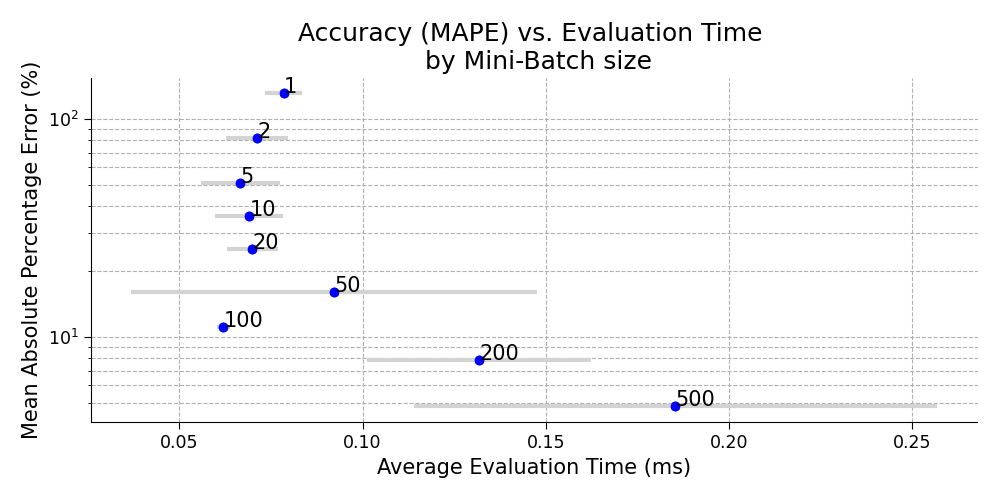

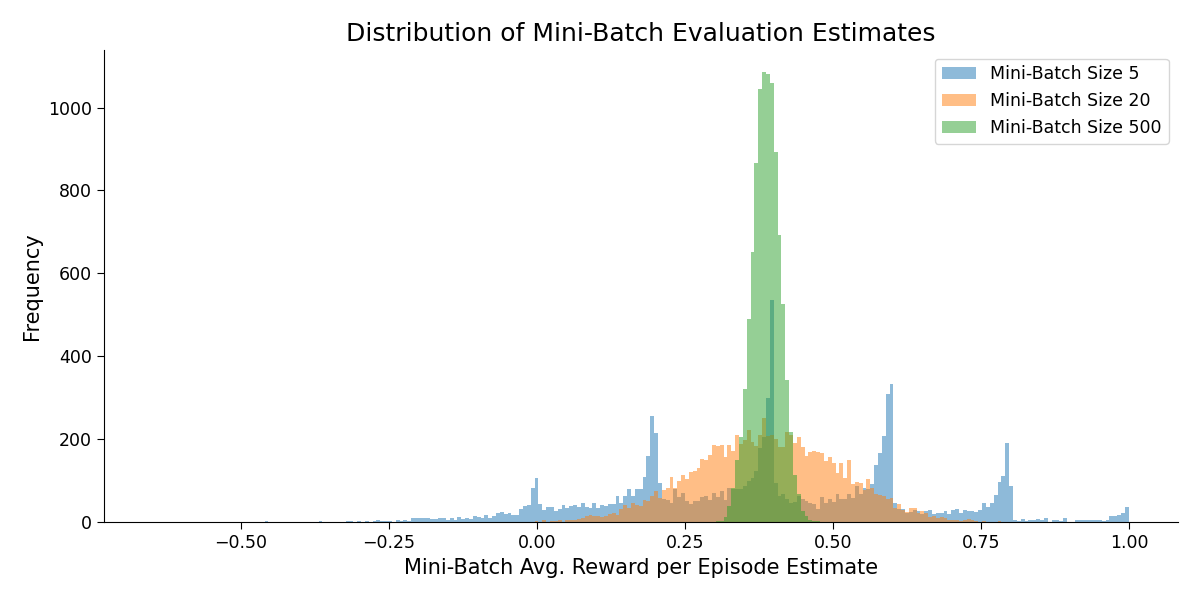

In [21]:
# @markdown **Run this cell** to see how accuracy and evaluation time trade-off against eachother as a function of mini-batch size when evaluating a particular set of parameters, $\mathbf{W}$.
learn_rng = np.random.default_rng(0)
step_scale = 0.002
mini_batch_size = 1
num_epochs = 5
dimensional_scale_factor = np.sqrt(65)
perturbation_scale = 0.0001 # std of gaussian test perturbations
W_init = np.zeros((1,65))
W = W_init
start_time = time.time()
indices = np.arange(Xs_aug.shape[0])
iterations = 0
for epoch in range(num_epochs):
  np.random.shuffle(indices)
  for batch_step in range(0, Xs_aug.shape[0], mini_batch_size):
    iterations += 1
    batch_indices = indices[batch_step:batch_step+mini_batch_size]
    batch_Xs = Xs_aug[batch_indices].T
    batch_y1 = y1[batch_indices].T
    R_current, _ = eval_params_expectation_batch(W, batch_Xs, batch_y1)
    raw_test_perturb = learn_rng.standard_normal(size=(1,65))
    unit_test_perturb = raw_test_perturb / np.linalg.norm(raw_test_perturb.flatten())
    test_perturbation = unit_test_perturb * perturbation_scale
    R_test, _ = eval_params_expectation_batch(W + test_perturbation, batch_Xs, batch_y1)
    directional_grad_est = (R_test - R_current) / perturbation_scale
    W += step_scale * dimensional_scale_factor * directional_grad_est * unit_test_perturb

reward_full_batch, _ = eval_params_expectation_batch(W, Xs_aug.T, y1.T)
avg_full_batch_reward = reward_full_batch / Xs.shape[0]

mini_batch_sizes = [1, 2, 5, 10, 20, 50, 100, 200, 500]
#mini_batch_sizes = [5, 20, 500]
mape_list = []
times_list = []
time_std_devs = []
sample_rewards = {}

for size in mini_batch_sizes:
  avg_rewards = []
  for _ in range(10000):
    rng.shuffle(indices)
    batch_indices = indices[:size]
    batch_Xs = Xs_aug[batch_indices].T
    batch_y1 = y1[batch_indices].T
    reward_mini_batch, _ = eval_params_expectation_batch(W, batch_Xs, batch_y1)
    avg_mini_batch_reward = reward_mini_batch / size
    avg_rewards.append(avg_mini_batch_reward)
  mape = np.mean(np.abs((avg_rewards - avg_full_batch_reward) / avg_full_batch_reward)) * 100
  mape_list.append(mape)
  sample_rewards[size] = avg_rewards  # Storing rewards for histogram
  batch_Xs = Xs_aug[:size].T
  batch_y1 = y1[:size].T
  print(f'timeit result for mini-batch of size {size}:')
  timeit_result = %timeit -o eval_params_expectation_batch(W, batch_Xs, batch_y1)
  times_list.append(timeit_result.average * 1000)
  time_std_devs.append(timeit_result.stdev * 1000)

plt.figure(figsize=(10, 5))
#lower_bounds = [mean - std for mean, std in zip(times_list, time_std_devs)]
#upper_bounds = [mean + std for mean, std in zip(times_list, time_std_devs)]

plt.errorbar(times_list, mape_list, xerr=time_std_devs, fmt='o', color='blue', ecolor='lightgray', elinewidth=3, capsize=0)
plt.scatter(times_list, mape_list, color='blue')
for i, txt in enumerate(mini_batch_sizes):
    plt.annotate(txt, (times_list[i], mape_list[i]))
plt.xlabel('Average Evaluation Time (ms)')
plt.ylabel('Mean Absolute Percentage Error (%)')
plt.yscale('log')  # Set the y-axis to a logarithmic scale
plt.title('Accuracy (MAPE) vs. Evaluation Time \n by Mini-Batch size')
plt.grid(True, which="both", ls="--")  # Adjust grid to appear properly on log scale
plt.show()

# Concatenate all rewards to determine optimal bin edges
all_data = np.concatenate([sample_rewards[size] for size in [5, 20, 500]])
# Determine optimal bin edges using the entire dataset
bin_edges = np.histogram_bin_edges(all_data, bins='auto')  # 'auto' lets numpy choose the optimal number of bins
# Plotting
plt.figure(figsize=(12, 6))
for size in [5, 20, 500]:
  plt.hist(sample_rewards[size], bins=bin_edges, alpha=0.5, label=f'Mini-Batch Size {size}')

plt.xlabel('Mini-Batch Avg. Reward per Episode Estimate')
plt.ylabel('Frequency')
plt.title('Distribution of Mini-Batch Evaluation Estimates')
plt.legend()
plt.show()



Note the high variability in evaluation time. Despite this a general trend is detectable. Below a certain mini-batch size, evaluation times are all very close, but eventuallly mini-batch size starts to have a large enough impact on evaluation time to be consistently detectable.

**Bonus Thinking Question**
Why are there funny little peaks in the mini-batch avg. reward per episode estimates for mini-batches of size 5?

**Answer**: These peak correspond to the number of viable striking opportunities in the mini-batch. With perfect performance an average reward per episode of 0, 0.2, 0.4, 0.6, 0.8 and 1 will be obtained (these correspond to the peaks) depending solely on the number of striking opportunities available in the mini-batch. From this we can see that the average reward recieved on a given mini-batch is strongly influenced both by the parameters governing behaviour and by the particular data points in the mini-batch.

The above simulation helps to illustrate how the trade-off between accuracy of evaluation and time per evaluation can change with batch size. It is important to note though the particular shape of this trade-off curve depends on **everything** about the problem, the size and and variability of the data, the complexity of the evaluation function, the implemention of the evaluation function and in particular how efficiently the evaluation function is implemented relative to the available hardware resources. Also how important accurate evalulations are for the learning algorithm can be hugely variable, so the implications of this trade-off need to be considered within the broader context of the optimization/learning problem. All that to say, mini-batches can be a very powerful tool to accelerate learning in an ML context, but some care is required to utilize them effectively.

# Algo Box: Mini-Batch

In many ML problems the goal is to find parameters $\theta$ such that some objective $J(\theta)$ is maximized or minimized. Further, in such problems this objective function is often defined in relation to a discrete and finite data set $\mathcal{D}$, as the sum of evaluations of some loss function, $l(\mathbf{d},\theta)$, with parameters $\theta$ and arguments $\mathbf{d} \in \mathcal{D}$, i.e.

$$ J(\theta) = \sum_{\mathbf{d} \in \mathcal{D}} l(\mathbf{d,\theta)} $$

Any iterative optimization algorithm will be evaluating either the objective function directly, or gradients of first (and possibly also second) order, as part of its optimization proccess. As the data set grows larger, i.e. contains more data points, evaluations of the objective function and its gradients, will require more compute. However, if many of the data points are similar (or even identical) all this extra computation may not be provide much additional information about how best to update the parameters $\theta$ to improve the objective $J(\theta)$.

An effective method to more efficiently utilize computational resources is mini-batch learning. In mini-batch learning, instead of using the entire data set to compute the parameter update, mini-batch learning uses a small, randomly selected subset of the data. This not only speeds up the computation but also introduces randomness into the optimization process, which can help in escaping local extrema, and hence find better global solutions. In psuedo code a full-batch training loop looks like:

___
* Set initial parameter guess for $\theta$
* While convergence condition not met:
    *  Update parameters according to $\theta \leftarrow \text{opt_step}(\theta,\mathcal{D})$
___
\
In constrast mini-batch training looks like:
___
* Set initial parameter guess for $\theta$
* While convergence condition not met:
    * Select a random subset $\mathcal{D}_{\text{mini}} \subset \mathcal{D}$ of fixed size $n$
    * Update parameters according to $\theta \leftarrow \text{opt_step}(\theta, \mathcal{D}_{\text{mini}})$
___

\
In practice mini-batches are typically not just sampled at random, but rather the entire data set is partioned randomly, and then learning proceeds by iterating through each distinct, non-overlapping mini-batch. After each mini-batch has been used the data set is shuffled and partioned again, to produce a new set of random mini-batches. This ensures that no one data point is given more importance during learning over another, and also that learning isn't overly influenced by any particular partioning. Each iteration through all the mini-batches is refered to as an *epoch*. Most mini-batch training loops use epochs and have this form:
___
* Set initial parameter guess for $\theta$
* While convergence condition not met:
    * New epoch, shuffle and partition dataset $\mathcal{D}$ into random mini-batches $\mathcal{D}_1, \mathcal{D}_2, \dots, \mathcal{D}_k$ of fixed size $n$
    * For each mini-batch $\mathcal{D}_i$:
        * Update parameters according to $\theta \leftarrow \text{opt_step}(\theta, \mathcal{D}_i)$
___

In the extreme case mini-batches can even consist of a single data point. The mini-batch idea developed in the context of Gradient Descent optimization so, for historical reasons learning with mini-batches of size 1 is called "Stochastic Gradient Descent". This historically grounded terminology is slightly confusing though as the mini-batch idea can and is usefully applied to many different iterative optimization algorithms. We will use the terms full-batch, mini-batch, and singleton based learning and evaluation to apply generally to any optimization process.

In practical ML settings, whenever the data-set becomes sufficiently large, mini-batches are almost always used, as they allow for the most efficient use of computational resources. However, determining the best mini-batch size is a tricky problem. Neither extreme is ideal. Full-batch learning provides the most accurate evaluation possible but is computationally expensive. Singleton learning is the least computationally expenisive but provides the least accurate evaluation. The mini-batch size that perfectly trades-off between these two factors, evaluation accuracy and computational time, will depend on many factors including:
 * Hardware that the computation is being run on
 * Implementation efficiency of the evaluation function and optimization process relative to the hardware
 * Variability of the underlying data-set
 * The optimization alogirithm being used
 * The type and structure of model being trained
All off these factors are important, and to make the problem of selecting mini-batch size harder, all of these factors interact to determine optimal mini-batch size.
___

Unfortunately, from a biological plausibility perpsective, smushing the update step and the perturbation step together, i.e. step-measure-step, does not mix well with the mini-batches. The key issue in combining these two ideas is that in the mini-batch training loops above **the same** mini-batch of data points was used to evaluate both the base parameters and the perturbed parameters alowing for a precise estimate of the rate of improvement in the direction of the test perturbation. If two **different** mini-batches are used to estimate the reward at two different points in the parameter space (as happens when we try to use step-measure-step with mini-batches). Using different mini-batches of data to estimate of the degree of improvement between the base and perturbed parameters adds so much noise to the process that learning becomes intractable. In some cases learning may still be possible but even if it is possible it will be too slow to be practical both in an ML context and in the context of rapdily aquiring adaptive behaviours.

Finally we turn our attention to using actual sampled rewards, instead of a computed expectation of reward.

In [22]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M3")

# 2.1.4.4 Recieved Reward Perturb-Measure-Step

Later on in this book we will see how an organism might develop an internal model of how their actions interact with the dynamics of the environment to change the state of the environment and produce rewards, but for the moment we are focused on arriving at the simplest viable learning circuit that can rapidly learn good behaviour on the strike-no-stike problem, while invoking only simple and easy to imagine physiological mechanisms of plasticity. So we wish to exclude the computation of expected reward, and instead focus on the actual rewards recieved by the organism and how they might drive synaptic weight changes. In the training loop below we implement perturb-measure-step but using stochastic evaluation. Let's see how it goes.

In [23]:
# @title Sampled-Reward Perturb-Measure-Step Training Loop
learn_rng = np.random.default_rng(0)
num_steps = 30000
step_scale = 0.000005
dimensional_scale_factor = np.sqrt(65)
perturbation_scale = 0.01 # std of gaussian test perturbations
W_init = np.zeros((1,65))
W = W_init
start_time = time.time()
for step in range(num_steps):
  R_current, _ = eval_params_stochastic_batch(W, Xs_aug.T, y1.T)
  raw_test_perturb = learn_rng.standard_normal(size=(1,65))
  unit_test_perturb = raw_test_perturb / np.linalg.norm(raw_test_perturb.flatten())
  test_perturbation = unit_test_perturb * perturbation_scale
  R_test, _ = eval_params_stochastic_batch(W + test_perturbation, Xs_aug.T, y1.T)
  directional_grad_est = (R_test - R_current) / perturbation_scale
  W += step_scale * dimensional_scale_factor * directional_grad_est * unit_test_perturb

  if step == 0 or (step + 1) % 3000 == 0:
    R_exp, _ = eval_params_expectation_batch(W, Xs_aug.T, y1.T)
    elapsed_time = time.time() - start_time
    print(f'Step {step + 1}/{num_steps} | Expected Full-Batch Reward: {R_exp:.6f} | Time: {elapsed_time:.2f}s | Avg. Time per Step: {1000*elapsed_time/iterations:.2f}ms')
eval_params_expectation_batch(W, Xs_aug.T, y1.T, verbose=True)

Step 1/30000 | Expected Full-Batch Reward: 56.372971 | Time: 0.00s | Avg. Time per Step: 0.00ms
Step 3000/30000 | Expected Full-Batch Reward: 1644.385103 | Time: 7.74s | Avg. Time per Step: 0.28ms
Step 6000/30000 | Expected Full-Batch Reward: 1811.603234 | Time: 13.22s | Avg. Time per Step: 0.47ms
Step 9000/30000 | Expected Full-Batch Reward: 1869.604888 | Time: 20.90s | Avg. Time per Step: 0.74ms
Step 12000/30000 | Expected Full-Batch Reward: 2063.439425 | Time: 26.27s | Avg. Time per Step: 0.93ms
Step 15000/30000 | Expected Full-Batch Reward: 1990.296655 | Time: 33.04s | Avg. Time per Step: 1.18ms
Step 18000/30000 | Expected Full-Batch Reward: 2065.067895 | Time: 39.24s | Avg. Time per Step: 1.40ms
Step 21000/30000 | Expected Full-Batch Reward: 1995.540357 | Time: 44.62s | Avg. Time per Step: 1.59ms
Step 24000/30000 | Expected Full-Batch Reward: 2066.031454 | Time: 52.10s | Avg. Time per Step: 1.85ms
Step 27000/30000 | Expected Full-Batch Reward: 2107.227613 | Time: 57.43s | Avg. Tim

So this works okay. The extra noise injected into the learning process by using stochastic evaluation of the reward function makes it harder for perturb-measure-step to "measure" the rate of improvement in a test direction, and as a result some learning occurs but it is slower and less effective than when we use the exact expected reward to measure/estimate the rate of improvement in the direction of the random test perturbation.

In [24]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M4")

# 2.1.4.5 Putting them all together

So there are simple ideas that overcome our key issues with perturb-measure-step as implemented initially. We can effectively learn from single experiences, we can effectively learn from actual rewards resulting from actual rewards made (not expectated reward given hypothetical probabilities of taking given actions), and we can effectively use the difference in reward between two episodes for learning instead of requiring a seperate perturbation evaluations mode of operation for the network. All of these are lovely ideas, however, they do not combine particularly well, at least not in a straightforward way. Learning is still possible when all of these ideas are combined, but improvement is so slow as to be totally impractical. Below is an example of learning not working.

In [25]:
# @title Sampled-Reward Singleton Step-Measure-Step Training Loop
# Delete or comment out the %%skip to run this cell
%%skip
learn_rng = np.random.default_rng(0)
num_epochs = 100
mini_batch_size = 1
step_scale =  0.000001
noise_scale = 0.0000005
W_init = np.zeros((1,65))
W = W_init
delta_W = np.zeros((1,65))
iteration=0
R, _ = eval_params_stochastic_batch(W, Xs_aug.T, y1.T)
start_time = time.time()
for epoch in range(num_epochs):
  np.random.shuffle(indices)
  for batch_step in range(0, Xs_aug.shape[0], mini_batch_size):
    iteration += 1
    batch_indices = indices[batch_step:batch_step+mini_batch_size]
    batch_Xs = Xs_aug[batch_indices].T
    batch_y1 = y1[batch_indices].T
    R_old = R
    R, _ = eval_params_stochastic_batch(W, batch_Xs, batch_y1)
    delta_R = R - R_old
    delta_W_noise = learn_rng.normal(0, noise_scale, size=(1,65))
    delta_W = total_scale * (step_scale * delta_W * delta_R + delta_W_noise)
    W += delta_W
  if epoch == 0 or (epoch + 1) % 10 == 0:
    total_expected_reward, _ = eval_params_expectation_batch(W, Xs_aug.T, y1.T)
    elapsed_time = time.time() - start_time
    print(f'Epoch {epoch + 1}/{num_epochs} | Steps: {iteration} | Expected Full-Batch Reward: {total_expected_reward:.6f} | Time: {elapsed_time:.2f}s | Avg. Time per Step: {1000*elapsed_time/iterations:.2f}ms')
eval_params_expectation_batch(W, Xs_aug.T, y1.T, verbose=True)

In [26]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M5")

# 2.1.4.6 Is Solving High Dimensional Optimization Problem Necissary for Adaptive Behaviour? Hard Yes.

From a machine learning perspective, when thinking about the performance of a model, there are several things that might be limiting performance. Maybe the data is fundamentally difficult, e.g. there are identical inputs with different correct outputs, i.e. $\mathbf{x} = \mathbf{x}'$, but $y = 0 $ and $y'=1$. Another possibility is that the learning algorithm being used is not effective given the model archetecture and the available data. Yet a third possibility is that archetecture of the model itstelf is not complex or flexible enough to capture the relevent patterns in the data. This last reason happens to be the case here.

One reason for having a large, flexible brain is to produce complex behaviour that is contingent on the state of the world in complex ways. The simple strike-no-strike network we've been using consists of a single layer of synaptic connections between the sensory inputs and the motor output. In a shallow network structure like this, a sensory input either directly inhibits or promotes the striking behaviour. There is no possibility for a sensory input to promote striking in some sensory contexts, but inhibit it in others. This is a deficincy. Context is important, loud thumping and roaring noises at a concert means the band is good, similar noises when camping in the wilderness means a large animal is nearby. A shallow network does not allow for such context dependence.

How do we allow for context dependence, or put another way, interactions between the inputs (beyond simply summing them together). As a starting point our current sensory-behavioural circuit is effectively equivalent to logistic regression, i.e. each sensory input element (feature in ML parlance) can either inhibit or potentiate striking behaviour to varying degrees, but there is no possibility for conditional interaction between features. By 'conditional interaction,' we mean a scenario where, for instance, feature 1 typically inhibits the behavior, except when feature 2 is positive, under which condition feature 1 becomes potentiating. These kinds of feature interactions are impossible in the current model. One way to allow for such interactions is to augment the base set of features with composite features, e.g. incorporate all the pairwise products of the existing feature set, so that instead of 65 features (bias included) we have $(\frac{64 \cdot 63}{2} + 64 + 64 + 1) = 2145$ features to work with. This could work, but what if we want something that depends on the interaction of more than 2 features, adding higher order polynomial terms will quickly make the problem intractable (Reference appendix section on why hidden layers not polynomials if we do that). If we had some mechanistically grounded understanding or hypothesis about the relationship between the features and the target we might be able to cherry pick some small subset of higher order interaction terms, but the ML mindset is in large part about automating the feature selection processes based on the data alone.

It turns out that instead of resorting the regression on polynomial terms to capture feature interactions, there is a much more compact and expressive way of allowing for feature interactions. The idea is to allow for feature interactions to emerge as needed in a 'hidden' computational layer of our highly abstracted neurons.

Simply adding an additional layer to the network, consisting of some intermediate (hidden) neurons between the inputs and the outputs, allows for context dependent inhibition and promotion of striking. There are theorems showing that a much as polynomials of arbitrarily high degree are a kind of universal function approximator (e.g. taylor series), simiarly networks with a singal (but potentially very large hidden layers) are a kind of universal function approximator (cites). With this in mind, let's see if adding a hidden layer to our network improves performance.

Our new strike-no-strike network with 1 hidden layer is structured as follows

As before $\mathbf{x}$ is the raw sensory input (vector) in a given episode and each element of $\mathbf{x}$ corresponds to the activation level and firing rate of a single photosensitive neuron.
These input neurons are then connected by synapses to a 'hidden layer' of intermediate computational neurons, say 10 of them. The activation level of these hidden layer neurons is computed as
$$\mathbf{h} = \sigma(\mathbf{W}_{in} \mathbf{x})$$
Now $\mathbf{W}_{in}$ is a matrix of synaptic weights between the input neurons and the hidden layer neurons. (In this case $\mathbf{W}$ has shape $10 \times 65$. Each the values in the $i^{th}$ row of $\mathbf{W}_{in}$ given the sign and strength of the connections coming into the $i^{th}$ element of $h$ and similarly each value in the $j^{th}$ column of $\mathbf{W}_{in}$ corresponds to connection strengths coming out of the $j^{th}$ sensory input neuron.)  We still us $\sigma$ to represent the standard logistic sigmoid function, but in this case applied elementwise the vector output of the standard matrix product $\mathbf{W}_{in} \mathbf{x}$. Then, much as before our striking probability is computed as
$$z = \mathbf{W}_{out} \cdot \mathbf{h}$$
and
$$ \Pr \{\text{strike}\} = \sigma(z) $$
$$ \Pr \{\text{no strike}\} = 1 - \sigma(z)$$
Here $\mathbf{W}_{out}$ has shape $1  \times 10$.


We will need to re-write a new eval params function for this new model, let's do it. To keep things quick and simple we will just use expecation based evaluation.

In [27]:
def eval_params_batch_expectation_hidden(W_in, W_out, x, y, verbose=False):
  """
  evaluates parameters of simple behaviour circuit given inputs and target
  outputs, use numpy broadcasting to be fast and concise
  Args:
    W_in: (hidden_neurons x inputs(65) np.array)
           weights between sensory neurons and hidden layer neurons
    W_out: (output(1) x hidden_neurons np.array)
           weights between hidden layer neurons and output
    x: (input(64) x batch np.array) sensory input
       (can be single input, mini-batch of inputs or the whole batch of inputs)
    y: (outputs(1) x batch np.array) target behavioural output
       (can be a single target, mini-batch of targets, or whole batch),
       needs to correspond to input

  Returns:
    R_exp: the average/expected total reward obtained given the parameters, over the
           (mini-)batch of inputs and targets. (mini-batch could be size 1)
  """
  # activation
  h = np_sigmoid(np.dot(W_in,x)) # hidden_neurons x batch
  strike_prob = np_sigmoid(np.dot(W_out,h)) # 1 x batch
  # Expected true positives (TPs) and false positives (FPs)
  TPs = np.sum(strike_prob * y)  # Sum of strike probabilities where true label is 1
  FPs = np.sum(strike_prob * (1 - y))  # Sum of strike probabilities where true label is 0
  # Expected false negatives (FN_e) and true negatives (TN_e)
  FNs = np.sum((1 - strike_prob) * y)  # Sum of no strike probabilities where true label is 1
  TNs = np.sum((1 - strike_prob) * (1 - y))  # Sum of no strike probabilities where true label is 0
  R_exp = 1 * TPs + 0 * FNs + -1 * FPs + 0 * TNs
  confusion_matrix = np.array([[TPs, FNs], [FPs, TNs]])
  if verbose:
    headers = ["", "Did Strike", "Didn't Strike"]
    table = [["Should Strike", TPs, FNs],
             ["Shouldn't Strike", FPs, TNs]]
    print("Confusion_matrix: ")
    print(tabulate(table, headers=headers, tablefmt="grid"))
    print(f'Total Reward: {R_exp}')
    return None
  else:
    return R_exp, confusion_matrix


We've got a more complicated circuit with more parameters, how much longer does it take us to evaluate this circuit compared to our previous one?

In [28]:
W = np.zeros((1,65))
%timeit eval_params_expectation_batch(W, Xs_aug.T, y1.T)

433 µs ± 17.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [29]:
W_in = np.zeros((10,65))
W_out = np.zeros((1,10))
%timeit eval_params_batch_expectation_hidden(W_in, W_out, Xs_aug.T, y1.T)

2.31 ms ± 141 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Roughly 5x longer per function evaluation, which means not only will we likely need more iterations of our algorithm because it is harder to find good parameters in high dimensions (we have 660 parameters now, which is a lot more than 65), but also each of those steps will take longer to process because function evaluations are also more costly. It will all be worth it if we can get better final performance though.

In [30]:
# @title 10 Hidden Units - Perturb-Measure-Step Training Loop
llearn_rng = np.random.default_rng(0)
num_steps = 20000
step_scale = 0.025
perturbation_scale = 0.0001 # std of gaussian test perturbations
num_hidden_units = 10
# initializing both layers as zero leads to some issues, so we
# use a Xavier/Glorot random initialization scheme
in_init = np.sqrt(6 / (65 + num_hidden_units))
W_in_init = learn_rng.uniform(-in_init, in_init, size=(num_hidden_units, 65))
out_init = np.sqrt(6 / (10 + 1))
W_out_init = learn_rng.uniform(-out_init, out_init, size=(1, num_hidden_units))
flat_params = np.concatenate((W_in_init.flatten(), W_out_init.flatten()))
dimensional_scale_factor = np.sqrt(len(flat_params))
start_time = time.time()
indices = np.arange(Xs_aug.shape[0])
for step in range(num_steps):
  W_in, W_out = np.split(flat_params, [65 * num_hidden_units])
  W_in = W_in.reshape((num_hidden_units,65))
  W_out = W_out.reshape((1,num_hidden_units))
  R_current, _ = eval_params_batch_expectation_hidden(W_in, W_out, Xs_aug.T, y1.T)
  raw_param_perturb = learn_rng.standard_normal(size=len(flat_params))
  unit_param_perturb = raw_param_perturb / np.linalg.norm(raw_param_perturb.flatten())
  test_perturbation = unit_param_perturb * perturbation_scale
  perturbed_flat_params = flat_params + test_perturbation
  W_in_test, W_out_test = np.split(perturbed_flat_params, [65 * num_hidden_units])
  W_in_test = W_in_test.reshape((num_hidden_units,65))
  W_out_test = W_out_test.reshape((1,num_hidden_units))
  R_test, _ = eval_params_batch_expectation_hidden(W_in_test, W_out_test, Xs_aug.T, y1.T)
  directional_grad_est = (R_test - R_current) / perturbation_scale
  flat_params += step_scale * dimensional_scale_factor * directional_grad_est * unit_param_perturb

  if step == 0 or (step + 1) % 1000 == 0:
    elapsed_time = time.time() - start_time
    print(f'Step {step + 1}/{num_steps} completed | Current Total Reward: {R_current:.6f} | Time elapsed: {elapsed_time:.2f} seconds')
W_in, W_out = np.split(flat_params, [65 * num_hidden_units])
W_in = W_in.reshape((num_hidden_units,65))
W_out = W_out.reshape((1,num_hidden_units))
eval_params_batch_expectation_hidden(W_in, W_out, Xs_aug.T, y1.T, verbose=True)


Step 1/20000 completed | Current Total Reward: -45.274586 | Time elapsed: 0.02 seconds
Step 1000/20000 completed | Current Total Reward: 2317.373498 | Time elapsed: 7.75 seconds
Step 2000/20000 completed | Current Total Reward: 2458.586042 | Time elapsed: 13.06 seconds
Step 3000/20000 completed | Current Total Reward: 2532.784529 | Time elapsed: 20.82 seconds
Step 4000/20000 completed | Current Total Reward: 2533.856985 | Time elapsed: 26.27 seconds
Step 5000/20000 completed | Current Total Reward: 2580.850743 | Time elapsed: 33.11 seconds
Step 6000/20000 completed | Current Total Reward: 2593.485026 | Time elapsed: 39.18 seconds
Step 7000/20000 completed | Current Total Reward: 2608.723901 | Time elapsed: 44.44 seconds
Step 8000/20000 completed | Current Total Reward: 2622.741925 | Time elapsed: 51.97 seconds
Step 9000/20000 completed | Current Total Reward: 2630.173666 | Time elapsed: 57.29 seconds
Step 10000/20000 completed | Current Total Reward: 2635.338410 | Time elapsed: 64.72 s

So this new, more complex circuit is great. We're much closer to the theoretical maximum performance of 2829, maybe with a few more hidden units, and a little longer training time we could have perfect discrimination. Let's see what happens when we go up to 20 hidden units. As a heads up this is going to take awhile (about 3 minutes) so you should read ahead while waiting for this training loop to complete

In [31]:
# @title 20 Hidden Units - Perturb-Measure-Step Training Loop
learn_rng = np.random.default_rng(0)
num_steps = 20000
step_scale = 0.025
perturbation_scale = 0.0001 # std of gaussian test perturbations
num_hidden_units = 20
# initializing both layers as zero leads to some issues, so we
# use a Xavier/Glorot random initialization scheme
in_init = np.sqrt(6 / (65 + num_hidden_units))
W_in_init = learn_rng.uniform(-in_init, in_init, size=(num_hidden_units, 65))
out_init = np.sqrt(6 / (10 + 1))
W_out_init = learn_rng.uniform(-out_init, out_init, size=(1, num_hidden_units))
flat_params = np.concatenate((W_in_init.flatten(), W_out_init.flatten()))
dimensional_scale_factor = np.sqrt(len(flat_params))
start_time = time.time()
indices = np.arange(Xs_aug.shape[0])
for step in range(num_steps):
  W_in, W_out = np.split(flat_params, [65 * num_hidden_units])
  W_in = W_in.reshape((num_hidden_units,65))
  W_out = W_out.reshape((1,num_hidden_units))
  R_current, _ = eval_params_batch_expectation_hidden(W_in, W_out, Xs_aug.T, y1.T)
  raw_param_perturb = learn_rng.standard_normal(size=len(flat_params))
  unit_param_perturb = raw_param_perturb / np.linalg.norm(raw_param_perturb.flatten())
  test_perturbation = unit_param_perturb * perturbation_scale
  perturbed_flat_params = flat_params + test_perturbation
  W_in_test, W_out_test = np.split(perturbed_flat_params, [65 * num_hidden_units])
  W_in_test = W_in_test.reshape((num_hidden_units,65))
  W_out_test = W_out_test.reshape((1,num_hidden_units))
  R_test, _ = eval_params_batch_expectation_hidden(W_in_test, W_out_test, Xs_aug.T, y1.T)
  directional_grad_est = (R_test - R_current) / perturbation_scale
  flat_params += step_scale * dimensional_scale_factor * directional_grad_est * unit_param_perturb

  if step == 0 or (step + 1) % 1000 == 0:
    elapsed_time = time.time() - start_time
    print(f'Step {step + 1}/{num_steps} completed | Current Total Reward: {R_current:.6f} | Time elapsed: {elapsed_time:.2f} seconds')
W_in, W_out = np.split(flat_params, [65 * num_hidden_units])
W_in = W_in.reshape((num_hidden_units,65))
W_out = W_out.reshape((1,num_hidden_units))
eval_params_batch_expectation_hidden(W_in, W_out, Xs_aug.T, y1.T, verbose=True)

Step 1/20000 completed | Current Total Reward: 48.540871 | Time elapsed: 0.01 seconds
Step 1000/20000 completed | Current Total Reward: 2522.235158 | Time elapsed: 11.05 seconds
Step 2000/20000 completed | Current Total Reward: 2568.403297 | Time elapsed: 22.21 seconds
Step 3000/20000 completed | Current Total Reward: 2602.456741 | Time elapsed: 31.27 seconds
Step 4000/20000 completed | Current Total Reward: 2632.122432 | Time elapsed: 42.51 seconds
Step 5000/20000 completed | Current Total Reward: 2637.008454 | Time elapsed: 53.48 seconds
Step 6000/20000 completed | Current Total Reward: 2624.436403 | Time elapsed: 64.59 seconds
Step 7000/20000 completed | Current Total Reward: 2660.195572 | Time elapsed: 73.75 seconds
Step 8000/20000 completed | Current Total Reward: 2664.208765 | Time elapsed: 84.70 seconds
Step 9000/20000 completed | Current Total Reward: 2674.062975 | Time elapsed: 95.90 seconds
Step 10000/20000 completed | Current Total Reward: 2689.732154 | Time elapsed: 107.16 

This more complex circuit gets us even closer to the theoretical maximum performance of 2829, but it's taking longer to get there. This is a consequence of both the function evaluations required at each step being slower (for the more complex function) and because more iterations are needed to effectively search the higher dimensional space for a good configuration of $\mathbf{W}_{in}$ and $\mathbf{W}_{out}$. With even more hidden units and more time we can likely learn perfect discrimination, but it will take even longer (more than 3 minutes!).

Although the toy neural circuit models in this sequence are a far cry from actual neural circuits, they still provide insight into possible mechanisms of synaptic plasticity the brain. We can imagine a scenario where synaptic strengths between neurons in a circuit undergo small, transient perturbations. The brain might integrate and compare the performance of these perturbations over a learning episode (for example, a day) to previous performance levels. (We leave aside the specifics of how this integration and comparison occur for now.)

If performance improves with a perturbation, synaptic changes could be consolidated in the direction of the perturbation, proportionate to the degree of improvement. Conversely, if performance worsens, changes might be consolidated in the opposite direction, also proportional to the performance decrease. This concept, while still vague, suggests a mechanism of synaptic adjustment based on performance feedback.

One critical point to consider is the scalability of such a learning process. The number of learning episodes required for effective optimization grows with the number of parameters in a neural circuit. This implies that 'perturb-measure-step' plasticity cannot be the primary mechanism driving neural plasticity in large, complex neural circuits that learn rapidly. This limitation is critical, the lifetimes of most animals simply aren't long enough to accommodate the number of learning iterations needed for extensive optimization.

However, as demonstrated above, a more complex circuit achieved significantly better performance in the discrimination task, so large complex circuits can be useful. This suggests that even if empirical evidence of perturbation-based learning in the brain exists and its physiological implementation is understood, such processes are unlikely to be the primary drivers of neural plasticity for complex and challenging behaviors.

(One counterargument in favor of simple learning rules is that extensive learning might not be necessary if genetic predisposition starts the circuit off close to an optimal parameter configuration. Then subsequently, relatively slow learning processes could 'fine-tune' the neural circuit's configuration. However, as noted in our earlier discussions on evolution, changing environments necessitate that a significant portion of behavior must emerge from learning, thereby limiting the extent to which genetic predispositions can facilitate efficient and adaptive learning.)

In this sequence we looked at how a simple neural circuit, and then a slightly more complex one were able to solve the strike-no-strike discrimination problem, when trained using perturb-measure-step. We found that several of the "unrealistic" aspects of perturb-measure-step (full batch learning, a seperate perturbation mode, used expected instead of actual reward to inform learning) could be mitigated, but only at the cost of slowing down learning (though using mini-batches in isolation, when evaluating the perturbation and current parameters on the same mini-batch was actually a speed up). Additionally we saw that using a more complex network (with hidden layers of increasing size) allowed for better perfomance on the discrimination task, but this extra performance came at a cost, function evaluation was more complex and there were more parameters to be optimized, and searching higher-dimensional spaces for good parameter configurations is always harder (more places to look, more directions to try, in addition to more compute required to for each test point evaluation).

In the next sequence we will introduce a different perspective on neural plasticity, one in which synaptic plasticity is driven between a mismatch between an expectation or prediction about reward, and the actual recieved reward.

In [32]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M6")

# E-Phys/Neuro Box
Neuroscientists have long conceptualized the learning process of neurons in terms of perturb, measure, step (cites). Synapses do not always produce an influence on the post-synaptic neuron if a spike comes in. In fact, they only produce a respose in about 50%% of all cases (cites, have figure element). We also know that there are mechanisms that can broadcast reward to all neurons, e.g. through Dopamine (cites). A neuron can then use a rule where learning is both proportional to rewards and proportional to the transmission at that point of time. The effect is that synapses whose existence helps make rewards higher gets consistently strengthened and those whose existence make rewards lower get consistently weakened. This way, single synapses can biophysically implement a global optimization algorithm.

[insert pictuere from fiete paper around here].

In our simple model of behaviour the pre-synaptic activity for synapse $w_i$ is $x_i$ and the post synaptic activity is $z = \sum_i {w_i} \cdot x_i$. We do not explicitly model spiking behaviour here though how stochastic spiking behaviour creates the perturbations necissary for perturb, measure, step has been extensively studied in (cites).


In [33]:
# @markdown Run this cell to display the box
%%html
<div style="background-color: #f2f2f2; border: 1px solid #d3d3d3; padding: 10px;">
    <p style="color: #333;"> Neuroscientists have long conceptualized *the* the learning process of neurons in terms of perturb, measure, step (cites). Synapses do not always produce an influence on the post-synaptic neuron if a spike comes in. In fact, they only produce a respose in about 50%% of all cases (cites, have figure element). We also know that there are mechanisms that can broadcast reward to all neurons, e.g. through Dopamine (cites). A neuron can then use a synaptic plasticity rule where strengthening (weakening if reward is negative) of the synaptic connection is both proportional to rewards and proportional to the transmission at that point in time. The effect is that synapses whose existence helps make rewards higher gets consistently strengthened and those whose existence make rewards lower get consistently weakened. This way, single synapses can biophysically implement a global optimization algorithm.

[insert pictuere from fiete paper around here].</p>
</div>


